In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also writ

/kaggle/input/dataset-test3/test.csv
/kaggle/input/data-set3/train.csv


In [25]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import uniform, randint, loguniform

import warnings
warnings.filterwarnings("ignore")

In [18]:
data_train = pd.read_csv("/kaggle/input/data-set3/train.csv")
data_test = pd.read_csv("/kaggle/input/dataset-test3/test.csv")

X_train = data_train.iloc[:, 6:]
X_test = data_test.iloc[:, 5:]

In [ ]:
y = data_train["PURITY"] / 100

# Diviser les données en train et validation
seed = 43
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.2, random_state=42)

# Standardisation des données (avant PCA)
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_valid_standardized = scaler.transform(X_valid)
X_test_standardized = scaler.transform(X_test)

# PCA sur les données standardisées
pca = PCA(n_components=42)  # 95% variance expliquée
X_train_pca = pca.fit_transform(X_train_standardized)
X_valid_pca = pca.transform(X_valid_standardized)
X_test_pca = pca.transform(X_test_standardized)

# Convertir en tensors PyTorch
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_pca, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)


In [28]:
# Définir le modèle de réseau de neurones simple

class FeedForwardNN(nn.Module):

    def __init__(self, input_size, lin_layer_sizes,

                 outpout_size, lin_layer_dropouts, activation):
        super().__init__()       
        if activation == 0:
            self.activation = nn.ReLU()
        elif activation == 1:
            self.activation = nn.SiLU()
        elif activation == 2:
            self.activation = nn.Tanh()
        elif activation == 3:
            self.activation = nn.LeakyReLU()  

        # Linear Layers
        first_lin_layer = nn.Linear(input_size, lin_layer_sizes[0])
        self.lin_layers = nn.ModuleList([first_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1]) for i in range(len(lin_layer_sizes) - 1)])     

        # Output Layer
        self.outpout_layer = nn.Linear(lin_layer_sizes[-1], outpout_size)
        
        # Dropout Layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(rate) for rate,size in zip(lin_layer_dropouts,lin_layer_sizes)])

    def forward(self, x):
        for lin_layer, dropout_layer in zip(self.lin_layers, self.dropout_layers):
            x = lin_layer(x)     
            x = self.activation(x)
            x = dropout_layer(x)
 
        x = self.outpout_layer(x)
        x = nn.Sigmoid()(x)
  

        return x

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, input_size, random_state, eta=0.001, max_epochs=100, batch=10, lin_layer_sizes = [50, 50],
            outpout_size = 1, lin_layer_dropouts = [0.4, 0.4], activation = 0):

        self.input_size = input_size
        self.random_state = random_state
        self.eta = eta
        self.max_epochs = max_epochs
        self.batch = batch
        self.lin_layer_sizes = lin_layer_sizes
        self.outpout_size = outpout_size
        self.lin_layer_dropouts = lin_layer_dropouts
        self.activation = activation
        self.model = FeedForwardNN(input_size, lin_layer_sizes,
                 outpout_size, lin_layer_dropouts, activation)

        self.criterion = nn.MSELoss()
    
    def fit(self, X, y, do_print=False):

        optimizer = optim.Adam(self.model.parameters(), lr=self.eta)
        X_tensor = torch.tensor(X).clone().detach().float()
        y_tensor = torch.tensor(y).clone().detach().float()
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch, shuffle=True)
        self.model.train()

        self.losses = []
        self.epochs = []
        
        # Training loop
        for epoch in range(self.max_epochs):

            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()  # Reset gradients
                outputs = self.model(batch_X)  # Forward pass
                loss = self.criterion(outputs, batch_y)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update parameters
                epoch_loss += loss.item()
                
            avg_epoch_loss = epoch_loss / len(dataloader)
            self.losses.append(avg_epoch_loss)
            self.epochs.append(epoch + 1)  # Ajouter l'époque (1-based)

            if do_print:
                print(f"Epoch {epoch+1}/{self.max_epochs}, Loss: {avg_epoch_loss}")

        return self  

    def get_losses(self):
        return self.losses

    def get_epochs(self):
        return self.epochs
        

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor).flatten()
        return outputs.numpy()
    def parameters(self):

        return self.model.parameters()

In [ ]:
class RandomLayers:
    def __init__(self,min_layers, max_layers, min_nodes, max_nodes):
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.min_layers = min_layers
        self.max_layers = max_layers

    def rvs(self, random_state=None):
        if random_state is not None:
            prev = randint.random_state
            randint.random_state = random_state 

        res = [[randint.rvs(self.min_nodes, self.max_nodes) for _ in range(randint.rvs(self.min_layers, self.max_layers))]]

        if random_state is not None:
            randint.random_state = prev

        return res

In [ ]:
class RandomDropout:
    def __init__(self, max_layers,min_dropout,max_dropout):
        self.min_dropout = min_dropout
        self.max_dropout = max_dropout
        self.max_layers = max_layers

    def rvs(self, random_state=None):
        if random_state is not None:
            prev = uniform.random_state
            uniform.random_state = random_state 
        res = [[uniform.rvs(self.min_dropout, self.max_dropout) for _ in range(self.max_layers)]]

        if random_state is not None:
            uniform.random_state = prev

        return res

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END activation=2, batch=27, eta=0.07114476009343425, lin_layer_dropouts=[0.07800932022121826, 0.07799726016810132, 0.02904180608409973, 0.4330880728874676, 0.3005575058716044], lin_layer_sizes=[124, 46, 103, 92], max_epochs=306;, score=-0.017 total time=  16.7s
[CV 2/5] END activation=2, batch=27, eta=0.07114476009343425, lin_layer_dropouts=[0.07800932022121826, 0.07799726016810132, 0.02904180608409973, 0.4330880728874676, 0.3005575058716044], lin_layer_sizes=[124, 46, 103, 92], max_epochs=306;, score=-0.019 total time=  17.0s
[CV 3/5] END activation=2, batch=27, eta=0.07114476009343425, lin_layer_dropouts=[0.07800932022121826, 0.07799726016810132, 0.02904180608409973, 0.4330880728874676, 0.3005575058716044], lin_layer_sizes=[124, 46, 103, 92], max_epochs=306;, score=-0.020 total time=  16.8s
[CV 4/5] END activation=2, batch=27, eta=0.07114476009343425, lin_layer_dropouts=[0.07800932022121826, 0.07799726016810132, 0

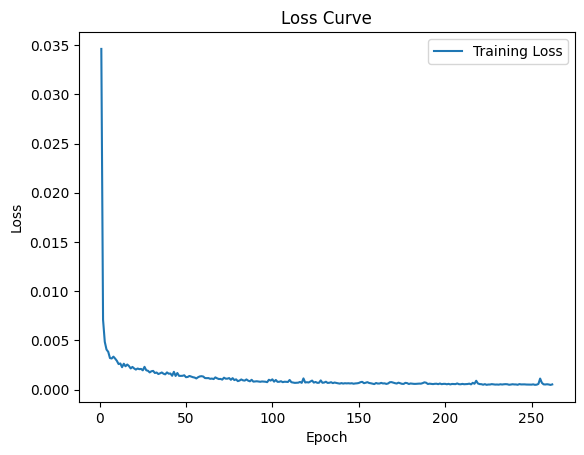

In [32]:
# Initialiser le modèle

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size, random_state=49)

max_layers = 4

# Définir les paramètres pour GridSearch
params_dist = {

    'eta': loguniform(1e-4, 1e-1),
    'max_epochs': randint(200, 400),
    'batch': randint(8, 32),
    'lin_layer_sizes': [[randint.rvs(32, 128) for _ in range(randint.rvs(1, 6))]],  # Taille de 1 à 4 couches, entre 32 et 128 neurones par couche
    'lin_layer_dropouts': [[uniform.rvs(0, 0.5) for _ in range(randint.rvs(1, 6))]],
    'activation': randint(0, 4),
}

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(net, params_dist, refit=True, cv=5, random_state=seed, scoring='neg_mean_squared_error', verbose=3, n_iter = 30)

# Entraîner le modèle avec GridSearch
random_grid_result = random_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = random_grid_result.best_estimator_
print("Best MSE: %f using %s" % (random_grid_result.best_score_, random_grid_result.best_params_))

losses = nouveau_model.get_losses()
epochs = nouveau_model.get_epochs()

# Tracer la courbe de la perte
plt.plot(epochs, losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [33]:
y_pred = nouveau_model.predict(X_valid_tensor)
y_pred_train = nouveau_model.predict(X_train_tensor)
predictions = nouveau_model.predict(X_test_tensor)*100

# Vérifiez les sorties du modèle
print("y_pred contains NaN:", np.isnan(y_pred).any())
# Calculer la MSE
mse = np.mean(((y_pred - y_valid)*100)**2)
print("MSE :", mse)

# Calculer le t_score
train_score = np.mean(np.abs(y_pred_train-y_train)*100<=5)
test_score = np.mean(np.abs(y_pred-y_valid)*100<=5)
print("t_score test :", train_score)
print("t_score train :", test_score)

ids = np.arange(1, len(predictions) + 1)

# Create a DataFrame for the output
output_df = pd.DataFrame({

    'ID': ids,

    'PURITY': predictions

})

# Save the DataFrame to a CSV file
output_df.to_csv('predictions.csv', index=False)

y_pred contains NaN: False
MSE : 4.96868925403041
t_score test : 0.9942307692307693
t_score train : 0.9461538461538461
